## Import

In [1]:
import sys
sys.path.append(r'\\Pund\Stab$\guest801968\Documents\GitHub\GeoSpatial-analysis\facility-location-Bergen\src\facility_location_Bergen\custome_modules')

In [2]:
import warnings
from shapely.errors import ShapelyDeprecationWarning
# Ignore the ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

In [3]:
import os
import random
import numpy as np
import pandas as pd
import pickle as pkl
import time as time_l
import networkx as nx
import plotly.io as pio
import geopandas as gpd
from copy import deepcopy
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from shapely.geometry import Point, LineString, Polygon
from log import print_INFO_message_timestamp, print_INFO_message
from retrieve_global_parameters import *

## Utility functions

### build_cc

In [4]:
def build_cc(G, strong=False):
    if not strong:
        if nx.is_directed(G):
            G = G.to_undirected()
        CCs = [nx.DiGraph(G.subgraph(c).copy()) for c in sorted(nx.connected_components(G), reverse=True, key=len)]
    else:
        CCs = [G.subgraph(c).copy() for c in sorted(nx.strongly_connected_components(G), reverse=True, key=len)]
    return CCs

### add_edge

In [5]:
def add_edge(node, G, only_successors=False, only_predecessors=False):
    speeds = []
    free_flow_speeds = []

    if only_predecessors and only_successors:
        print_INFO_message(f"at least one of only_predecessors and only_successors must be False")
        raise ValueError
    
    if not only_successors:
        predecessors = list(G.predecessors(node[0]))
        print_INFO_message(f"predecessors of {node[0]} is {predecessors}")
        for predecessor in predecessors:
            edge = (predecessor, node[0])
            speeds.append(list(G.edges(edge, data=True))[0][2]["speed"])
            free_flow_speeds.append(list(G.edges(edge, data=True))[0][2]["free_flow_speed"])
    
    if not only_predecessors:
        if G.has_node(node[1]):
            successors = list(G.successors(node[1]))
            print_INFO_message(f"successors of {node[1]} is {successors}")
            for successor in successors:
                edge = (node[1], successor)
                speeds.append(list(G.edges(edge, data=True))[1][2]["speed"])
                free_flow_speeds.append(list(G.edges(edge, data=True))[1][2]["free_flow_speed"])
    
    avg_speed = np.mean(speeds)
    avg_free_flow_speed = np.mean(free_flow_speeds)
    weight = node[2] / avg_speed
    weight2 = node[2] / avg_free_flow_speed
    print_INFO_message(f"average speed is {avg_speed}")
    print_INFO_message(f"weight is {weight}")
    G.add_edge(node[0],
                node[1],
                weight=weight,
                weight2=weight2,
                speed=avg_speed,
                free_flow_speed=avg_free_flow_speed)

### translate_path

In [6]:
def traslate_path(path, factor=0.01, traslate_first_node=False):
    new_path = []
    for n in range(len(path)-1):
        if path[n+1][0]-path[n][0] == 0:
            m = 0
        else:
            m_n = (path[n+1][1]-path[n][1])
            m_d = (path[n+1][0]-path[n][0])
        if  (m_n<0 and m_d<0) or (m_d<0 and m_n>0):
            p0 = np.array((path[n][0], path[n][1]+factor))
            p1 = np.array((path[n+1][0], path[n+1][1]+factor))
        else:
            p0 = np.array((path[n][0], path[n][1]-factor))
            p1 = np.array((path[n+1][0], path[n+1][1]-factor))
        l2 = np.sum((p0-p1)**2)
        t0 = np.sum((np.array(path[n])-p0)*(p1-p0))/l2
        t1 = np.sum((np.array(path[n+1])-p0)*(p1-p0))/l2
        if n == 0 and traslate_first_node:
            new_path.append(np.round(p0+t0*(p1-p0),5))
        elif n == 0 and not traslate_first_node:
            new_path.append(path[n])
        new_path.append(np.round(p0+t1*(p1-p0),5))
    return [tuple(p) for p in new_path]

### show_graph

In [7]:
def show_graph(F, display_jam=False):
  if type(F) != list:
    F = [F]
    
  if len(F) > 1 and display_jam:
    raise ValueError("display_jam can be True only if F is a single graph")
  
  colors = ["red", "blue", "green", "yellow", "orange", "purple", "brown"]
  tempo_colorscale = px.colors.get_colorscale("tempo")
  
  fig = go.Figure()

  for i, f in enumerate(F):
    if i < len(colors):
      color = colors[i]
    else:
      color = "black"
      
    nodes_lon = []
    nodes_lon_no_None = []
    nodes_lat = []
    nodes_lat_no_None = []
    weights = []
    color_weights = []
    for edge in f.edges(data=True):
          x0, y0 = edge[0]
          x1, y1 = edge[1]
          weight = edge[2]["weight"]
          nodes_lon.append(x0)
          nodes_lon.append(x1)
          nodes_lon.append(None)
          nodes_lat.append(y0)
          nodes_lat.append(y1)
          nodes_lat.append(None)
          nodes_lon_no_None.append(x0)
          nodes_lon_no_None.append(x1)
          nodes_lat_no_None.append(y0)
          nodes_lat_no_None.append(y1)
          weights.append(weight)
    
    max_weight = max(weights)
    min_weight = min(weights)
    for weight in weights:
      norm_weight = (weight-min_weight)/(max_weight-min_weight)
      color_weights.append(
          px.colors.find_intermediate_color(
            tempo_colorscale[0][1], 
            tempo_colorscale[-1][1], 
            norm_weight, 
            colortype="rgb"))
  
    if display_jam:
      for i, color in enumerate(color_weights):
        fig.add_trace(go.Scattermapbox(
              lat=nodes_lat_no_None[i:i+2],
              lon=nodes_lon_no_None[i:i+2],
              mode='lines+markers',
              line=dict(width=1, color=color),
              showlegend=False,
          ))
    else:
      fig.add_trace(go.Scattermapbox(
          lat=nodes_lat,
          lon=nodes_lon,
          mode='lines+markers',
          line=dict(width=1, color=color),
          showlegend=False,
      ))

    nodes = f.nodes()
    nodes = gpd.GeoDataFrame(pd.Series(list(nodes())).apply(lambda x: Point(x)), columns=["geometry"], crs="EPSG:4326")


    fig.add_trace(go.Scattermapbox(
    lat = nodes.geometry.y,
    lon = nodes.geometry.x,
    mode='markers',
    marker=dict(size=3, color="black"),
    showlegend=False,
  ))
    

  fig.update_layout(title="<b>Graph visualization<b>",
                      mapbox=dict(
                        style="open-street-map",
                        center=dict(lat=np.mean(pd.Series(nodes_lat).dropna()), lon=np.mean(pd.Series(nodes_lon).dropna())),
                        zoom=9
                        ),
                      title_pad_l=260,
                      height=700,
                      width=1000,)

  return  fig

## Data loading

In [65]:
root = rf"\/Pund\Stab$/guest801968/Documents/GitHub/GeoSpatial-analysis/facility-location-Bergen/"
times = ["all_day", "morning", "midday", "afternoon"]

In [66]:
average_graphs = {}
worst_average_graphs = {}

print_INFO_message_timestamp("loading average graphs")
for time in times:
    if time != "all_day_free_flow":
        print_INFO_message(f"average graphs for {time}")
        path = root + retrieve_average_graph_path(time, True)
        path_worst = root + retrieve_worst_average_graph_path(time, False)
        with open(path, "rb") as f:
            average_graphs[time] = pkl.load(f)
        with open(path_worst, "rb") as f:
            worst_average_graphs[time] = pkl.load(f)    

[09/04/23 11:15:15] INFO     loading average graphs
                    INFO     average graphs for all_day
                    INFO     average graphs for morning
                    INFO     average graphs for midday
                    INFO     average graphs for afternoon


## Data analysis

#### Strong connection

In [ ]:
print_INFO_message_timestamp("strongly connected components")
for key, G in average_graphs.items():
    print_INFO_message(f"{key}: {nx.number_strongly_connected_components(G)}")

print_INFO_message_timestamp("connected components")
for key, G in average_graphs.items():
    print_INFO_message(f"{key}: {nx.number_connected_components(G.to_undirected())}")

In [ ]:
CCs = {key: build_cc(G) for key, G in average_graphs.items()}

In [ ]:
print_INFO_message_timestamp("connected components")
for key, CC in CCs.items():
    for key2, CC2 in CCs.items():
        if key != key2:
            print_INFO_message(f"{key} vs {key2}:")
            identical = False
            for i, cc in enumerate(CC):
                if cc.edges() == CC2[i].edges():
                    identical = True
            print_INFO_message(f"cc are identical: {identical}")

## Data visualization

In [ ]:
fig = go.Figure()
time = times[0]
G = average_graphs[time]
fig = show_graph(G)
fig

In [ ]:
CCs = {key: build_cc(G,True) for key, G in average_graphs.items()}

In [ ]:
fig = go.Figure()
time = "all_day"
colors = ["red", "blue", "green", "yellow", "orange", "purple", "pink", "brown", "grey", "black"]

for i, cc in enumerate(CCs[time][1:10]):
    nodes_lon = []
    nodes_lat = []
    weights = []
    for edge in cc.edges(data=True):
        x0, y0 = edge[0]
        x1, y1 = edge[1]
        weight = edge[2]["weight"]
        nodes_lon.append(x0)
        nodes_lon.append(x1)
        nodes_lon.append(None)
        nodes_lat.append(y0)
        nodes_lat.append(y1)
        nodes_lat.append(None)
        weights.append(weight)
        
    fig.add_trace(go.Scattermapbox(
        lat=nodes_lat,
        lon=nodes_lon,
        mode='lines',
        line=dict(width=1, color=colors[i]),
        showlegend=False,
    ))

    nodes = cc.nodes()
    nodes = gpd.GeoDataFrame(pd.Series(list(nodes())).apply(lambda x: Point(x)), columns=["geometry"], crs="EPSG:4326")


    fig.add_trace(go.Scattermapbox(
    lat = nodes.geometry.y,
    lon = nodes.geometry.x,
    mode='markers',
    marker=dict(size=3, color="black"),
    showlegend=False,
    ))
  

fig.update_layout(title="<b>Graph visualization<b>",
                    mapbox=dict(
                      style="open-street-map",
                      center=dict(lat=60.3913, lon=5.3221),
                      zoom=9
                      ),
                    title_pad_l=260,
                    height=700,
                    width=1000,)

fig

## Define hand by hand connections

In [10]:
G = deepcopy(average_graphs["all_day"])
CCs = build_cc(G)

### Step: split carriage
<!--  -->

In [11]:
n1 = (5.31522, 60.39234)
n2 = (5.3184, 60.38643)

path1 = nx.dijkstra_path(G, n1, n2, weight="weight")
new_path1 = [(round(p[0],5), round(p[1],5)) for p in traslate_path(path1, 0.00005)]

In [12]:
edges1 = list(zip(path1[:len(path1)-1], path1[1:]))
new_edges1 = list(zip(new_path1[:len(new_path1)-1], new_path1[1:]))

In [13]:
print_INFO_message_timestamp("Splitting road carriageway")
for edge, new_edge in zip(edges1, new_edges1):
    for e in G.edges(edge, data=True):
        if e[0] == edge[0] and e[1] == edge[1]:
            print_INFO_message(f"replacing edge {e[0]}-{e[1]}")
            G.remove_edge(edge[0], edge[1])
            G.add_edge(new_edge[0], new_edge[1], **e[2])
            break

[07/24/23 11:18:45] INFO     Splitting road carriageway
                    INFO     replacing edge (5.31522, 60.39234)-(5.31508, 60.39212)
                    INFO     replacing edge (5.31508, 60.39212)-(5.31492, 60.39187)
                    INFO     replacing edge (5.31492, 60.39187)-(5.31483, 60.39176)
                    INFO     replacing edge (5.31483, 60.39176)-(5.3148, 60.39172)
                    INFO     replacing edge (5.3148, 60.39172)-(5.31424, 60.39126)
                    INFO     replacing edge (5.31424, 60.39126)-(5.31403, 60.39109)
                    INFO     replacing edge (5.31403, 60.39109)-(5.31385, 60.39094)
                    INFO     replacing edge (5.31385, 60.39094)-(5.31352, 60.39067)
                    INFO     replacing edge (5.31352, 60.39067)-(5.31331, 60.39049)
                    INFO     replacing edge (5.31331, 60.39049)-(5.31307, 60.39013)
                    INFO     replacing edge (5.31307, 60.39013)-(5.31365, 60.38946)
                    IN

### Step: delete non-existing carriage
<!--  -->

In [14]:
n1 = (5.3148, 60.39172)
n2 = path1[0]

In [15]:
path2 = nx.dijkstra_path(G, n1, n2, weight="weight")
edges2 = list(zip(path2[:len(path2)-1], path2[1:]))

In [16]:
print_INFO_message_timestamp("Deleting non-existing road")
for i, edge in enumerate(edges2):
    for e in G.edges(edge, data=True):
        if e[0] == edge[0] and e[1] == edge[1]:
            print_INFO_message(f"removing edge {e[0]}-{e[1]}")
            G.remove_edge(edge[0], edge[1])
            if i == 0:
                G.remove_node(edge[1])
            elif i == len(edges2)-1:
                G.remove_node(edge[0])
            else:
                G.remove_node(edge[0])
                G.remove_node(edge[1])
            break

[07/24/23 11:18:45] INFO     Deleting non-existing road
                    INFO     removing edge (5.3148, 60.39172)-(5.31483, 60.39176)
                    INFO     removing edge (5.31492, 60.39187)-(5.31508, 60.39212)


#### - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

In [108]:
path = nx.shortest_path(G,  (5.33166, 60.38781), (5.33255, 60.38493))

In [115]:
print_INFO_message_timestamp("Deleting non-existing road")
for edge0, edge1 in zip(path[:len(path)-1], path[1:]):
    for e in G.edges(data=True):
        if e[0] == edge0 and e[1] == edge1:
            print_INFO_message(f"removing edge {e[0]}-{e[1]}")
            G.remove_edge(edge0, edge1)
            break

[07/24/23 14:35:00] INFO     Deleting non-existing road
                    INFO     removing edge (5.33166, 60.38781)-(5.33191, 60.38695)
                    INFO     removing edge (5.33191, 60.38695)-(5.33209, 60.38636)
                    INFO     removing edge (5.33209, 60.38636)-(5.33255, 60.38493)


### Step: split node
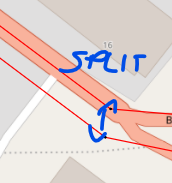

In [17]:
n1 = path1[-1]
n2 = (5.31874, 60.38635)

In [18]:
print_INFO_message_timestamp("Splitting node")
for e in G.edges((n1, n2), data=True):
    if e[0] == n1 and e[1] == n2:
        print_INFO_message(f"replacing edge {e[0]}-{e[1]}")
        G.remove_edge(e[0], e[1])
        G.add_edge(new_path1[-1], n2, **e[2])
        break

[07/24/23 11:18:45] INFO     Splitting node
                    INFO     replacing edge (5.3184, 60.38643)-(5.31874, 60.38635)


### Step: add new edges
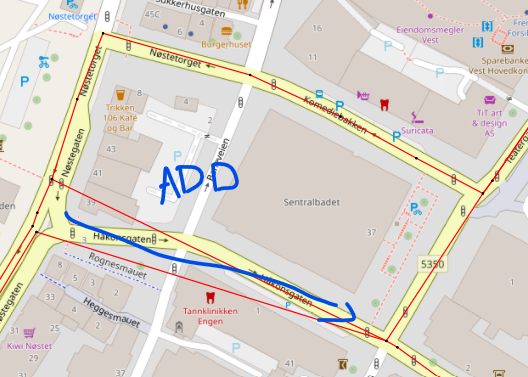

In [19]:
n1 = (5.3148, 60.39172)
n2 = (5.31701, 60.39138)
new_edges = [(n1, n2, 130),
             (new_path1[2], n2, 140)]

In [20]:
print_INFO_message_timestamp("Adding new edges to include primary roads")
for i, node in enumerate(new_edges):
    if G.has_edge(node[0], node[1]):
        print_INFO_message(f"edge {node[0]}-{node[1]} already exists")
        break
    
    if G.has_node(node[0]) and G.has_node(node[1]):
        add_edge(node, G)

[07/24/23 11:18:45] INFO     Adding new edges to include primary roads
                    INFO     predecessors of (5.3148, 60.39172) is [(5.31424, 60.39126)]
                    INFO     successors of (5.31701, 60.39138) is [(5.31708, 60.39136)]
                    INFO     average speed is 5.5055313426793555
                    INFO     weight is 23.61261645941941
                    INFO     predecessors of (5.3149, 60.39188) is [(5.31506, 60.39213)]
                    INFO     successors of (5.31701, 60.39138) is [(5.31708, 60.39136)]
                    INFO     average speed is 6.045022143338214
                    INFO     weight is 23.159551227497815


### Step: add new edges
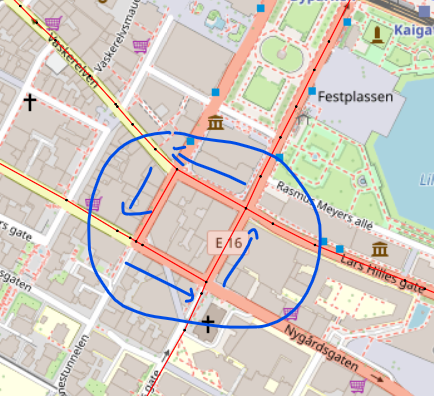

In [21]:
mapping = {(5.32347, 60.38933): (5.32235, 60.38977),
           (5.32318, 60.38902): (5.321005, 60.388545)}

In [22]:
G = nx.relabel_nodes(G, mapping)

In [23]:
new_node = (5.323551, 60.389427)
new_edges_1 = [((5.32246, 60.38974), new_node, 71)]
new_edges_2 = [(new_node, (5.32423, 60.39005), 80),
             ((5.32423, 60.39005), (5.32305, 60.39038), 75),
             ((5.32305, 60.39038), (5.32235, 60.38977), 77)]

In [24]:
print_INFO_message_timestamp("Adding new node and edges to the graph to make it connected")
for i, node in enumerate(new_edges_1):
    if G.has_edge(node[0], node[1]):
        print_INFO_message(f"edge {node[0]}-{node[1]} already exists")
        break
        
    if G.has_node(node[0]):
        add_edge(node, G)

    print_INFO_message(f"number of connected components: {nx.number_connected_components(G.to_undirected())}")

print_INFO_message_timestamp("Adding new edges to include primary roads")
for i, node in enumerate(new_edges_2):
    if G.has_edge(node[0], node[1]):
        print_INFO_message(f"edge {node[0]}-{node[1]} already exists")
        break
    
    if G.has_node(node[0]):
        if G.has_node(node[1]):
            add_edge(node, G)

[07/24/23 11:18:45] INFO     Adding new node and edges to the graph to make it connected
                    INFO     predecessors of (5.32246, 60.38974) is [(5.32235, 60.38977)]
                    INFO     average speed is 13.41142054758419
                    INFO     weight is 5.293995497948149
                    INFO     number of connected components: 1
[07/24/23 11:18:46] INFO     Adding new edges to include primary roads
                    INFO     predecessors of (5.323551, 60.389427) is [(5.32246, 60.38974)]
                    INFO     successors of (5.32423, 60.39005) is [(5.32448, 60.39032)]
                    INFO     average speed is 9.673011477232798
                    INFO     weight is 8.270433689476606
                    INFO     predecessors of (5.32423, 60.39005) is [(5.32469, 60.38992), (5.323551, 60.389427)]
                    INFO     successors of (5.32305, 60.39038) is [(5.32268, 60.39055)]
                    INFO     average speed is 6.39254939602245
 

### Step: add new edges
<!-- 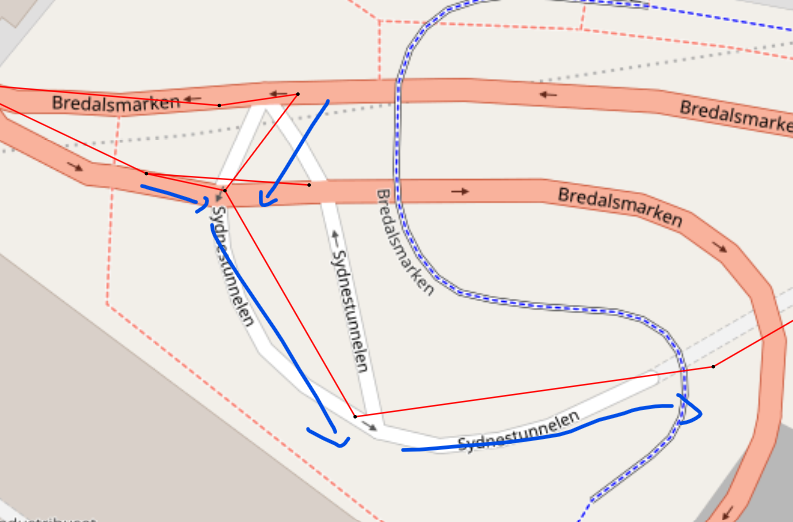 -->

In [25]:
new_node = (5.319112, 60.386136)
new_node2 = (5.319076, 60.386314)
new_edges_3 = [((5.31975, 60.38618), new_node, 40),
               (new_node, new_node2, 10),
               (new_node2, (5.31903, 60.38634), 5),
               (new_node2, (5.31887, 60.38641), 20),
               ]

In [26]:
print_INFO_message_timestamp("Adding new edges to include primary roads")
for i, node in enumerate(new_edges_3):
    if G.has_edge(node[0], node[1]):
        print_INFO_message(f"edge {node[0]}-{node[1]} already exists")
        break
        
    if G.has_node(node[0]):
        add_edge(node, G)

    print_INFO_message(f"number of connected components: {nx.number_connected_components(G.to_undirected())}")


[07/24/23 11:18:46] INFO     Adding new edges to include primary roads
                    INFO     predecessors of (5.31975, 60.38618) is [(5.32024, 60.38632)]
                    INFO     average speed is 13.41142054758419
                    INFO     weight is 2.9825326749003658


                    INFO     number of connected components: 1
                    INFO     predecessors of (5.319112, 60.386136) is [(5.31975, 60.38618)]
                    INFO     average speed is 13.41142054758419
                    INFO     weight is 0.7456331687250914
                    INFO     number of connected components: 1
                    INFO     predecessors of (5.319076, 60.386314) is [(5.319112, 60.386136)]
                    INFO     successors of (5.31903, 60.38634) is []
                    INFO     average speed is 13.41142054758419
                    INFO     weight is 0.3728165843625457
                    INFO     number of connected components: 1
                    INFO     predecessors of (5.319076, 60.386314) is [(5.319112, 60.386136)]
                    INFO     successors of (5.31887, 60.38641) is [(5.3184, 60.38643)]
                    INFO     average speed is 11.216854054904832
                    INFO     weight is 1.783031133515955
         

In [27]:
new_node_4 = (5.319842, 60.386277)
new_edges_4 = [((5.31903,60.38634), new_node_4, 56),
               (new_node_4, (5.31946, 60.38573), 85)]

In [28]:
print_INFO_message_timestamp("Adding new edges to include primary roads")
for i, node in enumerate(new_edges_4):
    if G.has_edge(node[0], node[1]):
        print_INFO_message(f"edge {node[0]}-{node[1]} already exists")
        break
        
    if G.has_node(node[0]):
        add_edge(node, G)

    print_INFO_message(f"number of connected components: {nx.number_connected_components(G.to_undirected())}")


[07/24/23 11:18:48] INFO     Adding new edges to include primary roads
                    INFO     predecessors of (5.31903, 60.38634) is [(5.31874, 60.38635), (5.319076, 60.386314)]
                    INFO     average speed is 11.187368142679357
                    INFO     weight is 5.005645589364514
                    INFO     number of connected components: 1
                    INFO     predecessors of (5.319842, 60.386277) is [(5.31903, 60.38634)]
                    INFO     successors of (5.31946, 60.38573) is [(5.31934, 60.38565)]
                    INFO     average speed is 13.548784326098097
                    INFO     weight is 6.2736255854534715
                    INFO     number of connected components: 1


### Step: add new edges
<!-- 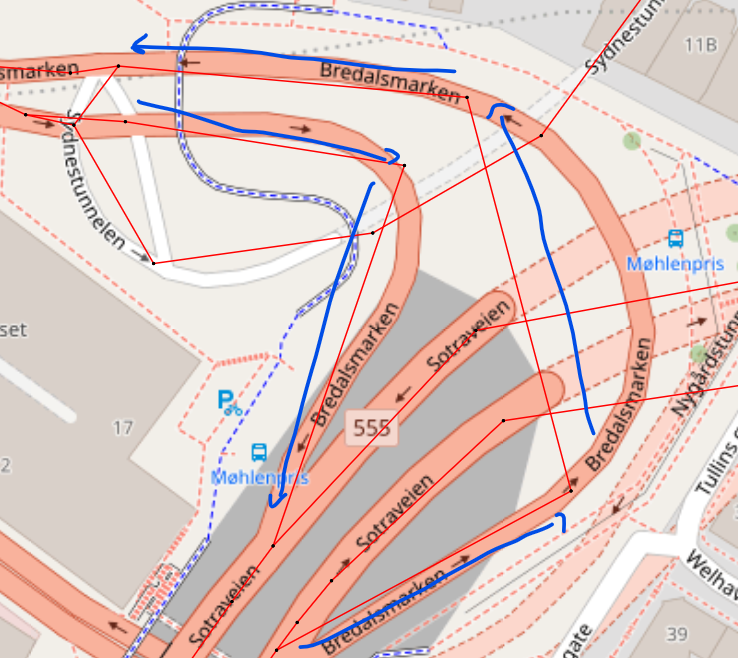 -->

In [29]:
new_node_5 = (5.320327, 60.385809)
new_node_6 = (5.320024, 60.386375)
new_edges_5 = [((5.31947, 60.38558), new_node_5, 65),
               (new_node_5, new_node_6, 80),
               (new_node_6, (5.31901, 60.38642), 50)]

In [30]:
print_INFO_message_timestamp("Adding new edges to include primary roads")
for i, node in enumerate(new_edges_5):
    if G.has_edge(node[0], node[1]):
        print_INFO_message(f"edge {node[0]}-{node[1]} already exists")
        break
        
    if G.has_node(node[0]):
        add_edge(node, G)

    print_INFO_message(f"number of connected components: {nx.number_connected_components(G.to_undirected())}")

[07/24/23 11:18:49] INFO     Adding new edges to include primary roads
                    INFO     predecessors of (5.31947, 60.38558) is [(5.31868, 60.38503)]
                    INFO     average speed is 16.078575392093704
                    INFO     weight is 4.042646715576702
                    INFO     number of connected components: 1
                    INFO     predecessors of (5.320327, 60.385809) is [(5.31947, 60.38558)]
                    INFO     average speed is 16.078575392093704
                    INFO     weight is 4.975565188402095
                    INFO     number of connected components: 1
                    INFO     predecessors of (5.320024, 60.386375) is [(5.320327, 60.385809)]
                    INFO     successors of (5.31901, 60.38642) is [(5.31887, 60.38641)]
                    INFO     average speed is 12.301732923352855
                    INFO     weight is 4.0644680153218955
                    INFO     number of connected components: 1


### Step: add new edges
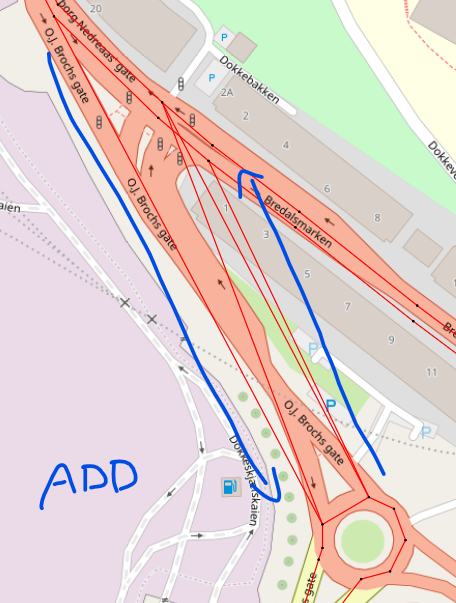

In [31]:
new_edges_6 = [((5.31563, 60.3875), (5.31702, 60.3862), 170),
               ((5.31619, 60.38728), (5.31702, 60.3862), 144),
               ((5.31726, 60.38627), (5.31643, 60.38713), 130),
               ((5.31726, 60.38627), (5.31619, 60.38728), 150)]

In [32]:
print_INFO_message_timestamp("Adding new edges to include primary roads")
for i, node in enumerate(new_edges_6):
    if G.has_edge(node[0], node[1]):
        print_INFO_message(f"edge {node[0]}-{node[1]} already exists")
        break
        
    if G.has_node(node[0]):
        add_edge(node, G)

    print_INFO_message(f"number of connected components: {nx.number_connected_components(G.to_undirected())}")

[07/24/23 11:18:50] INFO     Adding new edges to include primary roads
                    INFO     predecessors of (5.31563, 60.3875) is [(5.31386, 60.38921)]
                    INFO     successors of (5.31702, 60.3862) is [(5.31702, 60.38614)]
                    INFO     average speed is 8.369733473865299
                    INFO     weight is 20.311279986492906
                    INFO     number of connected components: 1
                    INFO     predecessors of (5.31619, 60.38728) is [(5.31645, 60.38717)]
                    INFO     successors of (5.31702, 60.3862) is [(5.31702, 60.38614)]
                    INFO     average speed is 8.399219386090778
                    INFO     weight is 17.14445038052774
                    INFO     number of connected components: 1
                    INFO     predecessors of (5.31726, 60.38627) is [(5.31739, 60.38624)]
                    INFO     successors of (5.31643, 60.38713) is [(5.31688, 60.38696)]
                    INFO     

### Step: add new edges
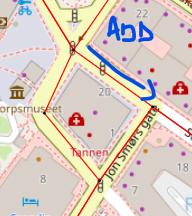

In [33]:
new_edge = [((5.32031, 60.39494), (5.32107, 60.39467), 57)]

In [34]:
print_INFO_message_timestamp("Adding new edges to include primary roads")
for i, node in enumerate(new_edge):
    if G.has_edge(node[0], node[1]):
        print_INFO_message(f"edge {node[0]}-{node[1]} already exists")
        break
        
    if G.has_node(node[0]):
        add_edge(node, G)

    print_INFO_message(f"number of connected components: {nx.number_connected_components(G.to_undirected())}")

[07/24/23 11:18:52] INFO     Adding new edges to include primary roads
                    INFO     predecessors of (5.32031, 60.39494) is [(5.31995, 60.39523), (5.32066, 60.39519)]
                    INFO     successors of (5.32107, 60.39467) is [(5.32226, 60.39425), (5.32056, 60.39432)]
                    INFO     average speed is 4.605229606132116
                    INFO     weight is 12.37723303179094


                    INFO     number of connected components: 1


### Step: add new edges
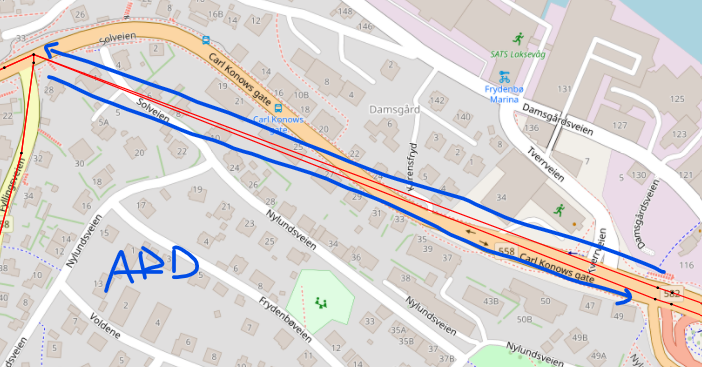

In [35]:
n1 = (5.3119, 60.38318)
n2 = (5.30421, 60.3846)
n3 = (5.31187, 60.38311) 
new_edges = [(n1, n2, 500),
             (n2, n3, 500)]

In [36]:
print_INFO_message_timestamp("Adding new edges to include primary roads")
for i, node in enumerate(new_edges):
    if G.has_edge(node[0], node[1]):
        print_INFO_message(f"edge {node[0]}-{node[1]} already exists")
        break
        
    if G.has_node(node[0]):
        add_edge(node, G)

[07/24/23 11:18:53] INFO     Adding new edges to include primary roads
                    INFO     predecessors of (5.3119, 60.38318) is [(5.31208, 60.38315)]
                    INFO     successors of (5.30421, 60.3846) is [(5.30385, 60.38452), (5.30421, 60.38455)]
                    INFO     average speed is 9.96746412806247
                    INFO     weight is 50.163210378886276
                    INFO     predecessors of (5.30421, 60.3846) is [(5.30421, 60.38455), (5.30385, 60.38452), (5.3119, 60.38318)]
                    INFO     successors of (5.31187, 60.38311) is [(5.31207, 60.38308)]
                    INFO     average speed is 8.945827483003905
                    INFO     weight is 55.89197879681286


### Step: add new edges and nodes

In [37]:
n1 = (5.31461, 60.38249)
n2 = (5.313629, 60.382463)
n3 = (5.312089, 60.382814)
n4 = (5.3119, 60.38318)
n5 = (5.31344, 60.38283)

new_edges = [(n1, n2, 55),
             (n2, n3, 93),
             (n3, n4, 54),
             (n3, n5, 85)]

In [38]:
print_INFO_message_timestamp("Adding new edges to include primary roads")
for i, node in enumerate(new_edges):
    if G.has_edge(node[0], node[1]):
        print_INFO_message(f"edge {node[0]}-{node[1]} already exists")  
    elif G.has_node(node[0]):
        add_edge(node, G)

[07/24/23 11:18:53] INFO     Adding new edges to include primary roads
                    INFO     predecessors of (5.31461, 60.38249) is [(5.31511, 60.38264)]
                    INFO     average speed is 18.847405765739385
                    INFO     weight is 2.918173497382776
                    INFO     predecessors of (5.313629, 60.382463) is [(5.31461, 60.38249)]
                    INFO     average speed is 10.20701180058565
                    INFO     weight is 9.111383607361354
                    INFO     predecessors of (5.312089, 60.382814) is [(5.313629, 60.382463)]
                    INFO     successors of (5.3119, 60.38318) is [(5.30421, 60.3846)]
                    INFO     average speed is 9.643525543045389
                    INFO     weight is 5.599611859683736
                    INFO     predecessors of (5.312089, 60.382814) is [(5.313629, 60.382463)]
                    INFO     successors of (5.31344, 60.38283) is [(5.31433, 60.38263)]
                    I

### Step: Complete roundabout

In [8]:
file_name = [r"\average_graph_all_day_connected_2.pkl",
             r"\average_graph_afternoon_connected_2.pkl", 
             r"\average_graph_morning_connected_2.pkl", 
             r"\average_graph_midday_connected_2.pkl"]
path = r"\\Pund\Stab$\guest801951\Documents\GitHub\GeoSpatial-analysis\facility-location-Bergen\data\03_primary"
graphs = {}
for name in file_name[:]:
    with open(path+name, 'rb') as f:
        graphs[name] = pkl.load(f)

In [55]:
round_1 = [((5.34044, 60.3561), (5.34017, 60.35609), 3),
             ((5.34015, 60.35596), (5.34044, 60.35594), 3)]

round_2 = [((5.34366, 60.36231), (5.34322, 60.36366), 150),
           ((5.34309, 60.36376), (5.34326, 60.36233), 140),
           ((5.34253, 60.36027), (5.34363, 60.36213), 190),
           ((5.34322, 60.36216), (5.34263, 60.36065), 180)]

round_3 = [((5.33785, 60.32509), (5.33768, 60.3252), 3),
           ((5.33768, 60.3252), (5.33722, 60.32508), 4),
           ((5.33722, 60.32501), (5.33758, 60.32488), 4)]

round_4 = [((5.35578, 60.31324), (5.3611, 60.31031), 500),
           ((5.3611, 60.31031), (5.35564, 60.31332), 500)]

round_5 = [((5.32874, 60.2999), (5.33013, 60.30089), 120),
           ((5.32988, 60.30095), (5.32832, 60.29972), 190),
           ((5.32986, 60.30098), (5.32843, 60.30154), 170)]

round_6 = [((5.32809, 60.29866), (5.32787, 60.29871), 3),
            ((5.32774, 60.29848), (5.3279, 60.29845), 3)]

round_7 = [((5.32717, 60.29692), (5.32688, 60.29696), 3),
           ((5.3268, 60.29677), (5.32711, 60.29675), 3)]

round_8 = [((5.34806, 60.26287), (5.34571, 60.26347), 150),
           ((5.34571, 60.26347), (5.34806, 60.26287), 150)]

round_9 = [((5.23461, 60.36448), (5.23442, 60.3645), 3),
           ((5.23438, 60.36439), (5.23461, 60.36439), 3)]

round_10 = [((5.25028, 60.36831), (5.24987, 60.36836), 3),
            ((5.24973, 60.36812), (5.25009, 60.36806), 3),
            ((5.25091, 60.36871), (5.25031, 60.36827), 85),
            ((5.25022, 60.36811), (5.25067, 60.36786), 40)]

rund_11 = [((5.28845, 60.35114), (5.2882, 60.35118), 3),
           ((5.28812, 60.35102), (5.28841, 60.351), 3)]

round_12 = [((5.28227, 60.51625), (5.2823, 60.51635), 3),
            ((5.28196, 60.51624), (5.2822, 60.51622), 3),
            ((5.28132, 60.51754), (5.282, 60.5164), 180),
            ((5.28616, 60.51602), (5.28307, 60.51667), 180),
            ((5.2823, 60.51635), (5.28385, 60.51628), 110)]

round_13 = [((5.28578, 60.51532), (5.285087, 60.516291), 120),
            ((5.285087, 60.516291), (5.28589, 60.516), 67),
            ((5.28585, 60.51597), (5.28587, 60.51588), 3)]

round_14 = [((5.33431, 60.4723), (5.33398, 60.47227), 3),
            ((5.33407, 60.47208), (5.3344, 60.47211), 3)]

round_15 = [((5.3315, 60.47411), (5.33157, 60.47423), 3)]

round_16 = [((5.35051, 60.35995), (5.35031, 60.35998), 3),
            ((5.35025, 60.35991), (5.35041, 60.35985), 3)]

roundabouts = [round_1, round_2, round_3, round_4, round_5, round_6, 
               round_7, round_8, round_9, round_10, rund_11, round_12, 
               round_13, round_14, round_15, round_16]

In [67]:
print_INFO_message_timestamp("Adding new edges to complete roundabouts")
for round in roundabouts:
    for i, node in enumerate(round):
        for key, G in worst_average_graphs.items():
            if G.has_edge(node[0], node[1]):
                print_INFO_message(f"edge {node[0]}-{node[1]} already exists")  
            elif G.has_node(node[0]):
                add_edge(node, G)

[09/04/23 11:15:19] INFO     Adding new edges to complete roundabouts
                    INFO     edge (5.34044, 60.3561)-(5.34017, 60.35609) already exists
                    INFO     edge (5.34044, 60.3561)-(5.34017, 60.35609) already exists
                    INFO     edge (5.34044, 60.3561)-(5.34017, 60.35609) already exists
                    INFO     edge (5.34044, 60.3561)-(5.34017, 60.35609) already exists
                    INFO     edge (5.34015, 60.35596)-(5.34044, 60.35594) already exists
                    INFO     edge (5.34015, 60.35596)-(5.34044, 60.35594) already exists
                    INFO     edge (5.34015, 60.35596)-(5.34044, 60.35594) already exists
                    INFO     edge (5.34015, 60.35596)-(5.34044, 60.35594) already exists
                    INFO     edge (5.34366, 60.36231)-(5.34322, 60.36366) already exists
                    INFO     edge (5.34366, 60.36231)-(5.34322, 60.36366) already exists
                    INFO     edge (5.34366, 

In [57]:
print_INFO_message_timestamp("Adding new edges to complete roundabouts")
for round in roundabouts:
    for i, node in enumerate(round):
        for key, G in average_graphs.items():
            if G.has_edge(node[0], node[1]):
                print_INFO_message(f"edge {node[0]}-{node[1]} already exists")  
            elif G.has_node(node[0]):
                add_edge(node, G)

[09/04/23 11:13:07] INFO     Adding new edges to complete roundabouts
                    INFO     edge (5.34044, 60.3561)-(5.34017, 60.35609) already exists
                    INFO     edge (5.34044, 60.3561)-(5.34017, 60.35609) already exists
                    INFO     edge (5.34044, 60.3561)-(5.34017, 60.35609) already exists
                    INFO     edge (5.34044, 60.3561)-(5.34017, 60.35609) already exists
                    INFO     edge (5.34015, 60.35596)-(5.34044, 60.35594) already exists
                    INFO     edge (5.34015, 60.35596)-(5.34044, 60.35594) already exists
                    INFO     edge (5.34015, 60.35596)-(5.34044, 60.35594) already exists
                    INFO     edge (5.34015, 60.35596)-(5.34044, 60.35594) already exists
                    INFO     edge (5.34366, 60.36231)-(5.34322, 60.36366) already exists
                    INFO     edge (5.34366, 60.36231)-(5.34322, 60.36366) already exists
                    INFO     edge (5.34366, 

### Step: add new edges

In [58]:
new_edges = [((5.3309, 60.47421), (5.32776, 60.47125), 400),
             ((5.32813, 60.47105), (5.3315, 60.47411), 400),
             
             ((5.33369, 60.47542), (5.33127, 60.47439), 200),
             ((5.33154, 60.4743), (5.332214, 60.474508), 50),
             ((5.332214, 60.474508), (5.33175, 60.47326), 200),
             
             ((5.33413, 60.47388), (5.33402, 60.47551), 290),
             
             ((5.32612, 60.46341), (5.32523, 60.46521), 290),
             ((5.3238, 60.46357), (5.325324, 60.464067), 79),
             ((5.325324, 60.464067), (5.32587, 60.46341), 84),
             
             ((5.32429, 60.46425), (5.322719, 60.463360), 140),
             ((5.322719, 60.463360), (5.32229, 60.46381), 52),
             ((5.32232, 60.46383), (5.32232, 60.46389), 3),
             ((5.32207, 60.46391), (5.32205, 60.46383), 3),
             ((5.32208, 60.46381), (5.32151, 60.46225), 210),
             
             ((5.32608, 60.39188), (5.32807, 60.39308), 220),
             
             ((5.48132, 60.3611), (5.45189, 60.3572), 2000),
             ((5.45189, 60.3572), (5.48132, 60.3611), 2000),
             
             ((5.34148, 60.3739), (5.34003, 60.37486), 600)]

In [68]:
print_INFO_message_timestamp("Adding new edges")
for i, node in enumerate(new_edges):
    for key, G in worst_average_graphs.items():
        if G.has_edge(node[0], node[1]):
            print_INFO_message(f"edge {node[0]}-{node[1]} already exists")  
        elif G.has_node(node[0]):
            add_edge(node, G)

[09/04/23 11:15:23] INFO     Adding new edges
                    INFO     edge (5.3309, 60.47421)-(5.32776, 60.47125) already exists
                    INFO     edge (5.3309, 60.47421)-(5.32776, 60.47125) already exists
                    INFO     edge (5.3309, 60.47421)-(5.32776, 60.47125) already exists
                    INFO     edge (5.3309, 60.47421)-(5.32776, 60.47125) already exists
                    INFO     edge (5.32813, 60.47105)-(5.3315, 60.47411) already exists
                    INFO     edge (5.32813, 60.47105)-(5.3315, 60.47411) already exists
                    INFO     edge (5.32813, 60.47105)-(5.3315, 60.47411) already exists
                    INFO     edge (5.32813, 60.47105)-(5.3315, 60.47411) already exists
                    INFO     edge (5.33369, 60.47542)-(5.33127, 60.47439) already exists
                    INFO     edge (5.33369, 60.47542)-(5.33127, 60.47439) already exists
                    INFO     edge (5.33369, 60.47542)-(5.33127, 60.47439

In [60]:
print_INFO_message_timestamp("Adding new edges")
for i, node in enumerate(new_edges):
    for key, G in average_graphs.items():
        if G.has_edge(node[0], node[1]):
            print_INFO_message(f"edge {node[0]}-{node[1]} already exists")  
        elif G.has_node(node[0]):
            add_edge(node, G)

[09/04/23 11:13:26] INFO     Adding new edges
                    INFO     edge (5.3309, 60.47421)-(5.32776, 60.47125) already exists
                    INFO     edge (5.3309, 60.47421)-(5.32776, 60.47125) already exists
                    INFO     edge (5.3309, 60.47421)-(5.32776, 60.47125) already exists
                    INFO     edge (5.3309, 60.47421)-(5.32776, 60.47125) already exists
                    INFO     edge (5.32813, 60.47105)-(5.3315, 60.47411) already exists
                    INFO     edge (5.32813, 60.47105)-(5.3315, 60.47411) already exists
                    INFO     edge (5.32813, 60.47105)-(5.3315, 60.47411) already exists
                    INFO     edge (5.32813, 60.47105)-(5.3315, 60.47411) already exists
                    INFO     edge (5.33369, 60.47542)-(5.33127, 60.47439) already exists
                    INFO     edge (5.33369, 60.47542)-(5.33127, 60.47439) already exists
                    INFO     edge (5.33369, 60.47542)-(5.33127, 60.47439

In [63]:
root = rf"\/Pund\Stab$/guest801968/Documents/GitHub/GeoSpatial-analysis/facility-location-Bergen/"
times = ["all_day", "morning", "midday", "afternoon"]

In [72]:
print_INFO_message_timestamp("loading average graphs")
for time in times:
    if time != "all_day_free_flow":
        print_INFO_message(f"average graphs for {time}")
        # path = root + retrieve_average_graph_path(time, True)
        # path = path.replace(f"{time}.pkl", f"{time}_connected.pkl")
        path_worst = root + retrieve_worst_average_graph_path(time, False)
        path_worst = path_worst.replace(f"{time}.pkl", f"{time}_connected.pkl")
        # with open(path, "rb") as f:
        #     average_graphs[time] = pkl.load(f)
        with open(path_worst, "wb") as f:
            pkl.dump(worst_average_graphs[time], f)

[09/04/23 11:19:01] INFO     loading average graphs
                    INFO     average graphs for all_day
                    INFO     average graphs for morning
                    INFO     average graphs for midday
                    INFO     average graphs for afternoon


### Visualize the connections

In [9]:
G = graphs[list(graphs.keys())[0]]

In [10]:
CCs = build_cc(G, True)

In [11]:
fig = show_graph(CCs[0])
fig

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ \\Pund\Stab$\guest801951\Documents\GitHub\GeoSpatial-analysis\kedro-env\lib\site-packages\IPytho │
│ n\core\formatters.py:223 in catch_format_error                                                   │
│                                                                                                  │
│    220 def catch_format_error(method, self, *args, **kwargs):                                    │
│    221 │   """show traceback on failed format call"""                                            │
│    222 │   try:                                                                                  │
│ ❱  223 │   │   r = method(self, *args, **kwargs)                                                 │
│    224 │   except NotImplementedError:                                                           │
│    225 │   │   # don't warn on NotImplementedErrors                                              │
│    226 │   │   return self._check_return(None, args[0])                                          │
│                                                                                                  │
│ \\Pund\Stab$\guest801951\Documents\GitHub\GeoSpatial-analysis\kedro-env\lib\site-packages\IPytho │
│ n\core\formatters.py:922 in __call__                                                             │
│                                                                                                  │
│    919 │   │   │   # Finally look for special method names                                       │
│    920 │   │   │   method = get_real_method(obj, self.print_method)                              │
│    921 │   │   │   if method is not None:                                                        │
│ ❱  922 │   │   │   │   method()                                                                  │
│    923 │   │   │   │   return True                                                               │
│    924                                                                                           │
│    925                                                                                           │
│                                                                                                  │
│ \\Pund\Stab$\guest801951\Documents\GitHub\GeoSpatial-analysis\kedro-env\lib\site-packages\plotly │
│ \basedatatypes.py:834 in _ipython_display_                                                       │
│                                                                                                  │
│    831 │   │   import plotly.io as pio                                                           │
│    832 │   │                                                                                     │
│    833 │   │   if pio.renderers.render_on_display and pio.renderers.default:                     │
│ ❱  834 │   │   │   pio.show(self)                                                                │
│    835 │   │   else:                                                                             │
│    836 │   │   │   print(repr(self))                                                             │
│    837                                                                                           │
│                                                                                                  │
│ \\Pund\Stab$\guest801951\Documents\GitHub\GeoSpatial-analysis\kedro-env\lib\site-packages\plotly │
│ \io\_renderers.py:396 in show                                                                    │
│                                                                                                  │
│   393 │   │   │   )                                                                              │
│   394 │   │                                                                                      │
│   395 │   │   if not nbformat or Version(nbformat.__version

Figure({
    'data': [{'lat': [60.42212, 60.42259, None, ..., 60.46336, 60.46381, None],
              'line': {'color': 'red', 'width': 1},
              'lon': [5.51596, 5.51347, None, ..., 5.322719, 5.32229, None],
              'mode': 'lines',
              'showlegend': False,
              'type': 'scattermapbox'},
             {'lat': array([60.42212 , 60.42231 , 60.42195 , ..., 60.474508, 60.464067, 60.46336 ]),
              'lon': array([5.51596 , 5.51624 , 5.4605  , ..., 5.332214, 5.325324, 5.322719]),
              'marker': {'color': 'black', 'size': 3},
              'mode': 'markers',
              'showlegend': False,
              'type': 'scattermapbox'}],
    'layout': {'height': 700,
               'mapbox': {'center': {'lat': 60.373004257665684, 'lon': 5.316229631206727},
                          'style': 'open-street-map',
                          'zoom': 9},
               'template': '...',
               'title': {'pad': {'l': 260}, 'text': '<b>Graph visualization<b>'},
               'width': 1000}
})

In [1]:
fig = go.Figure()
time = "all_day"
#colors = ["red", "blue", "green", "yellow", "orange", "purple", "pink", "brown", "grey", "black"]

for i, cc in enumerate(CCs[1:]):
    nodes_lon = []
    nodes_lat = []
    weights = []
    for edge in cc.edges(data=True):
        x0, y0 = edge[0]
        x1, y1 = edge[1]
        weight = edge[2]["weight"]
        nodes_lon.append(x0)
        nodes_lon.append(x1)
        nodes_lon.append(None)
        nodes_lat.append(y0)
        nodes_lat.append(y1)
        nodes_lat.append(None)
        weights.append(weight)
        
    fig.add_trace(go.Scattermapbox(
        lat=nodes_lat,
        lon=nodes_lon,
        mode='lines',
        line=dict(width=1),
        showlegend=False,
    ))

    nodes = cc.nodes()
    nodes = gpd.GeoDataFrame(pd.Series(list(nodes())).apply(lambda x: Point(x)), columns=["geometry"], crs="EPSG:4326")


    fig.add_trace(go.Scattermapbox(
    lat = nodes.geometry.y,
    lon = nodes.geometry.x,
    mode='markers',
    marker=dict(size=8, color="black"),
    showlegend=False,
    ))

fig.update_layout(title="<b>Graph visualization<b>",
                    mapbox=dict(
                      style="open-street-map",
                      center=dict(lat=60.3913, lon=5.3221),
                      zoom=9
                      ),
                    title_pad_l=260,
                    height=700,
                    width=1000,)

fig

NameError: name 'go' is not defined

In [ ]:
fig = go.Figure()
time = "all_day"
#colors = ["red", "blue", "green", "yellow", "orange", "purple", "pink", "brown", "grey", "black"]

for i, cc in enumerate(CCs[:1]):
    nodes_lon = []
    nodes_lat = []
    weights = []
    for edge in cc.edges(data=True):
        x0, y0 = edge[0]
        x1, y1 = edge[1]
        weight = edge[2]["weight"]
        nodes_lon.append(x0)
        nodes_lon.append(x1)
        nodes_lon.append(None)
        nodes_lat.append(y0)
        nodes_lat.append(y1)
        nodes_lat.append(None)
        weights.append(weight)
        
    fig.add_trace(go.Scattermapbox(
        lat=nodes_lat,
        lon=nodes_lon,
        mode='lines',
        line=dict(width=1, color="red"),
        showlegend=False,
    ))

    nodes = cc.nodes()
    nodes = gpd.GeoDataFrame(pd.Series(list(nodes())).apply(lambda x: Point(x)), columns=["geometry"], crs="EPSG:4326")


    fig.add_trace(go.Scattermapbox(
    lat = nodes.geometry.y,
    lon = nodes.geometry.x,
    mode='markers',
    marker=dict(size=3, color="black"),
    showlegend=False,
    ))

fig.update_layout(title="<b>Graph visualization<b>",
                    mapbox=dict(
                      style="open-street-map",
                      center=dict(lat=60.3913, lon=5.3221),
                      zoom=9
                      ),
                    title_pad_l=260,
                    height=700,
                    width=1000,)

fig

## Two way roads split

### Data loading

In [4]:
root = rf"\/Pund/Stab$/guest801951/Documents/GitHub/GeoSpatial-analysis/facility-location-Bergen/"
times = ["all_day", "morning", "midday", "afternoon"]
connected = True

In [5]:
average_graphs = {}

print_INFO_message_timestamp("loading average graphs")
for time in times:
    if time != "all_day_free_flow":
        print_INFO_message(f"average graphs for {time}")
        path = root + retrieve_average_graph_path(time, connected)
        with open(path, "rb") as f:
            average_graphs[time] = pkl.load(f)

[08/04/23 09:27:21] INFO     loading average graphs
                    INFO     average graphs for all_day
                    INFO     average graphs for morning


                    INFO     average graphs for midday
                    INFO     average graphs for afternoon


In [6]:
G = average_graphs["all_day"]

### Utility functions

In [7]:
def clear_log(log_file_path):
    with open(log_file_path, "w") as f:
        f.write("")

In [8]:
def check_double_sense_continues(G, node):
    successors = list(G.successors(node))
    no_double_sense = True
    for s in successors:
        if G.has_edge(s, node):
            no_double_sense = False
            break
    return (successors, no_double_sense)

In [9]:
def img_log(G, node_list, node_mapping, node_class=[]):
    fig = go.Figure()
    for node in node_list: 
        nodes_lon = []
        nodes_lat = []
        weights = []
        nodes = []
        predecessors = list(G.predecessors(node))
        successors = list(G.successors(node))
        for edge in G.edges(data=True):
            if edge[0] == node or edge[1] == node \
            or edge[0] in predecessors or edge[1] in successors \
            or edge[0] in successors or edge[1] in predecessors:       
                x0, y0 = edge[0]
                x1, y1 = edge[1]
                weight = edge[2]["weight"]
                nodes_lon.append(x0)
                nodes_lon.append(x1)
                nodes_lon.append(None)
                nodes_lat.append(y0)
                nodes_lat.append(y1)
                nodes_lat.append(None)
                weights.append(weight)
                nodes.append(edge[0])
                nodes.append(edge[1])
                                    
        fig.add_trace(go.Scattermapbox(
                                                lat=nodes_lat,
                                                lon=nodes_lon,
                                                mode='lines',
                                                line=dict(width=1, color="red"),
                                                showlegend=False,
                                            ))
                                    
        nodes = gpd.GeoDataFrame(
                                pd.Series(nodes).apply(lambda x: Point(x)), 
                                columns=["geometry"], 
                                crs="EPSG:4326")
        text = []
        for n in nodes.geometry:
            text.append("")
            if (n.x, n.y) in node_mapping.keys():
                text[-1] += str(node_mapping[(n.x, n.y)])
            else:
                text[-1] += "-"
            if (n.x, n.y) in node_class.keys():
                text[-1] += f" {str(node_class[(n.x, n.y)])}"
        
        fig.add_trace(go.Scattermapbox(
                                    lat = nodes.geometry.y,
                                    lon = nodes.geometry.x,
                                    mode='markers+text',
                                    marker=dict(size=5, color="black"),
                                    text = text,
                                    showlegend=False,
                                ))  
        
    fig.update_layout(mapbox=dict(
                                style="open-street-map",
                                center=dict(lat=np.mean(nodes.geometry.y), lon=np.mean(nodes.geometry.x)),
                                zoom=16
                                ),
                        height=700,
                        width=600,)

    return fig

In [10]:
def node_mapping_log(G, node):
    node_mapping = {node: 0}
    node_class = {node: ["origin"]}
    i = 1
    for edge in G.edges(data=True):
        if edge[0] == node:
            if edge[1] not in node_mapping.keys():
                node_mapping[edge[1]] = i
                i += 1
            if edge[1] not in node_class.keys():
                node_class[edge[1]] = ["successor"]
            else:
                node_class[edge[1]].append("successor")
        if edge[1] == node:
            if edge[0] not in node_mapping.keys():
                node_mapping[edge[0]] = i
                i += 1
            if edge[0] not in node_class.keys():
                node_class[edge[0]] = ["predecessor"]
            else:
                node_class[edge[0]].append("predecessor")
    return node_mapping, node_class

In [11]:
def split_the_node_input(node, node_mapping, message="split the node "):
    split_the_node = input(message+f"{node_mapping[node]}? (y/n): ")
    if split_the_node == "y":
        return True
    elif split_the_node == "n":
        return False
    else:
        return split_the_node_input(node, node_mapping, "invalid input. split the node ")

In [12]:
def select_pre_and_suc_input(node, G, node_mapping, message=""):
    node_mapping_r = {v: k for k, v in node_mapping.items()}
    predecessors = list(G.predecessors(node))
    successors = list(G.successors(node))
    try:
        predecessor, successor = input(message+
                                       "select a predecessor and a successor of "+
                                       f"{node_mapping[node]} (comma separated): ").split(",")
        predecessor = node_mapping_r[int(predecessor)]
        successor = node_mapping_r[int(successor)]
    except:
        return select_pre_and_suc_input(node, G, node_mapping, "invalid input. ")

    if predecessor not in predecessors:
        return select_pre_and_suc_input(node, G, node_mapping, "not a predecessor. ")
    elif successor not in successors:
        return select_pre_and_suc_input(node, G, node_mapping, "not a successor. ")
    else:
        return predecessor, successor

In [13]:
def new_edges_input(node_mapping, message="insert new connections (label0, label1, distance(m); ...): "):
    new_edges = input(message)
    node_mapping_r = {v: k for k, v in node_mapping.items()}
    if new_edges == "":
        new_edges = []
    else:
        new_edges = new_edges.split(";")
        if "" in new_edges:
            new_edges.remove("")
        try:
            new_edges = [(int(e.split(",")[0]), int(e.split(",")[1]), int(e.split(",")[2])) for e in new_edges]
            new_edges = [(node_mapping_r[e[0]], node_mapping_r[e[1]], e[2]) for e in new_edges]    
        except:
            new_edges = new_edges_input(node_mapping, "invalid input, try again (label+distance(m) semicolon separated):")
    return new_edges

In [14]:
def edges_to_delete_input(node_mapping, message="insert edges to delete (label0, label1; ...): "):
    edges_to_delete = input(message)
    node_mapping_r = {v: k for k, v in node_mapping.items()}
    if edges_to_delete == "":
        edges_to_delete = []
    else:
        try:
            edges_to_delete = edges_to_delete.split(";")
            if "" in edges_to_delete:
                edges_to_delete.remove("")
            edges_to_delete = [(int(e.split(",")[0]), int(e.split(",")[1])) for e in edges_to_delete]
            edges_to_delete = [(node_mapping_r[e[0]], node_mapping_r[e[1]]) for e in edges_to_delete]
        except:
            edges_to_delete = new_edges_input(node_mapping, "invalid input, try again (tuple label semicolon separated):")
    return edges_to_delete

In [15]:
def reconnect_predecessors(G, origin, log_file_path, node, new_edge):
    print_INFO_message(f"replacing edge {origin}-{node}", log_file_path)
    predecessors = list(G.predecessors(origin))
    for p in predecessors:
        for e in G.edges((p, origin), data=True):
            if e[0] == p and e[1] == origin:
                if nx.has_path(G, p, node) and p!=node:                  
                    print_INFO_message(f"processing predecessor: {p}", log_file_path)
                    G.remove_edge(p, origin)
                    G.add_edge(p, new_edge[0], **e[2])
                    break

In [42]:
def split_the_node_func(G, log_file_path2, img_path, history_changes, node, node_mapping, node_class, get_data_from_input=True):
    if get_data_from_input:
        selected_predecessor, selected_successor = select_pre_and_suc_input(node, G, node_mapping)
        history_changes[node]['selected_predecessor'] = selected_predecessor
        history_changes[node]['selected_successor'] = selected_successor
        print_INFO_message(f"selected predecessor: {selected_predecessor}", log_file_path2)
        print_INFO_message(f"selected successor: {selected_successor}", log_file_path2)
        new_edge = traslate_path([(node[0], node[1]), (selected_successor[0], selected_successor[1])], 0.00005, True)
        node_mapping[new_edge[0]] = max(list(node_mapping.values()))+1
        for e in G.edges((selected_predecessor, node), data=True):
            if e[0] == selected_predecessor and e[1] == node:
                G.add_edge(selected_predecessor, new_edge[0], **e[2])
                G.remove_edge(selected_predecessor, node)
                break
        for e in G.edges((node, selected_successor), data=True):
            if e[0] == node and e[1] == selected_successor:
                G.add_edge(new_edge[0], selected_successor, **e[2])
                G.remove_edge(node, selected_successor)
                break
                                        
        fig = img_log(G, [node, new_edge[0]], node_mapping, node_class)
        fig.write_html(img_path, full_html=True, auto_open=True)
    else:
        selected_predecessor = history_changes[node]['selected_predecessor']
        selected_successor = history_changes[node]['selected_successor']
        new_edge = traslate_path([(node[0], node[1]), (selected_successor[0], selected_successor[1])], 0.00005, True)
        node_mapping[new_edge[0]] = max(list(node_mapping.values()))+1
        for e in G.edges((selected_predecessor, node), data=True):
            if e[0] == selected_predecessor and e[1] == node:
                G.add_edge(selected_predecessor, new_edge[0], **e[2])
                G.remove_edge(selected_predecessor, node)
                break
        for e in G.edges((node, selected_successor), data=True):
            if e[0] == node and e[1] == selected_successor:
                G.add_edge(new_edge[0], selected_successor, **e[2])
                G.remove_edge(node, selected_successor)
                break

In [16]:
def split_two_way_roads(G, origin, count=0, count_max=1, 
                        log_file_path=None, log_file_path2 = None, clear_log_file=True, img_path=None,
                        history_changes = {},):
    if clear_log_file:
        clear_log(log_file_path)
        clear_log(log_file_path2)
        
    print_INFO_message_timestamp(f"count: {count}", log_file_path)    
    if count > count_max:
        return
    
    successors = list(G.successors(origin))
    # print_INFO_message_timestamp(f"origin: {origin}", log_file_path)
    for i, node in enumerate(successors):
        # print_INFO_message(f"succerssors number: {i}", log_file_path)
        if G.has_edge(node, origin):
            print_INFO_message(f"TWO WAY STREET FOUND", log_file_path)
            new_edge = traslate_path([(origin[0], origin[1]), (node[0], node[1])], 0.00005, True)
            for e in G.edges((origin, node), data=True):
                if e[0] == origin and e[1] == node:
                    reconnect_predecessors(G, origin, log_file_path, node, new_edge)
                    
                    print_INFO_message(f"old edge is {(origin, node)}", log_file_path)
                    print_INFO_message(f"new edge is {(new_edge[0], node)}", log_file_path)   
                    G.remove_edge(origin, node) 
                    G.add_edge(new_edge[0], node, **e[2])
                        
                    successors, no_double_sense = check_double_sense_continues(G, node)
                    is_crossroad = len(successors) > 2
                    print_INFO_message_timestamp(f"no_double_sense: {no_double_sense}", log_file_path)
                    if no_double_sense or is_crossroad: 
                        node_mapping, node_class = node_mapping_log(G, node) 
                        if node in history_changes.keys():
                            for k in ['split_the_node', 'selected_predecessor', 'selected_successor', 'new_edges', 'edges_to_delete']:
                                if k not in history_changes[node].keys():
                                    raise Exception(f"key {k} not in history_changes[{node}]")
                                
                            print_INFO_message_timestamp(f"node {node} already in history_changes")
                            print_INFO_message(history_changes[node])
                            
                            if history_changes[node]['split_the_node']:
                                split_the_node_func(G, log_file_path2, img_path, history_changes, node, node_mapping, node_class, False)
                                   
                            for e in history_changes[node]['new_edges']:
                                add_edge(e, G)
                            
                            for e in history_changes[node]['edges_to_delete']:
                                G.remove_edge(e[0], e[1])
                            
                        else:
                            history_changes[node] = {}
                            fig = img_log(G, [node], node_mapping, node_class)
                            fig.write_html(img_path, full_html=True, auto_open=True)
                            
                            split_the_node = split_the_node_input(node, node_mapping)
                            history_changes[node]['split_the_node'] = split_the_node
                            print_INFO_message_timestamp(f"split the node {node}? (y/n): {split_the_node}", log_file_path2)
                            
                            if split_the_node:
                                while split_the_node:
                                    split_the_node_func(G, log_file_path2, img_path, history_changes, node, node_mapping, node_class)
                                    node_mapping, node_class = node_mapping_log(G, node) 
                                    split_the_node = split_the_node_input(node, node_mapping, "split again the node ")
                    
                            new_edges = new_edges_input(node_mapping)
                            history_changes[node]['new_edges'] = new_edges
                            for e in new_edges:
                                add_edge(e, G)
                            print_INFO_message(f"new edges: {new_edges}", log_file_path2)
                            
                            edges_to_delete = edges_to_delete_input(node_mapping)
                            history_changes[node]['edges_to_delete'] = edges_to_delete
                            for e in edges_to_delete:
                                G.remove_edge(e[0], e[1])
                            print_INFO_message(f"edges to delete: {edges_to_delete}", log_file_path2)

                            fig = img_log(G, [node], node_mapping, node_class)
                            fig.write_html(img_path, full_html=True, auto_open=True)
                            input("press enter to continue")
                    break

        split_two_way_roads(G, node, count+1, count_max, 
                            log_file_path=log_file_path, 
                            log_file_path2=log_file_path2,
                            clear_log_file=False, 
                            img_path=img_path,
                            history_changes=history_changes)
    

### Graph processing

In [47]:
F = deepcopy(G)#(5.31461, 60.38249)

log_file_path = r"\\Pund\Stab$\guest801951\Documents\GitHub\GeoSpatial-analysis\facility-location-Bergen\logs\split_roads.log"
log_file_path2 = r"\\Pund\Stab$\guest801951\Documents\GitHub\GeoSpatial-analysis\facility-location-Bergen\logs\split_roads_changes.log"
img_path = r"\\Pund\Stab$\guest801951\Documents\GitHub\GeoSpatial-analysis\facility-location-Bergen\logs\img_split_roads.html"

nodes = list(F.nodes())
seed = random.seed(5487654)
history_changes = {}

print_INFO_message_timestamp("Splitting two way roads")
for i in range(10):
    if i == 0:
        clear_log_file = True
    else:
        clear_log_file = False
        
    origin = random.choice(nodes)
    print_INFO_message(f"iteration:{i}, origin: {origin}")
    split_two_way_roads(F, 
                        origin=origin, 
                        count_max=10, 
                        clear_log_file=clear_log_file,
                        log_file_path=log_file_path,
                        log_file_path2=log_file_path2, 
                        img_path=img_path,
                        history_changes=history_changes)

[08/02/23 13:31:58] INFO     Splitting two way roads
                    INFO     iteration:0, origin: (5.29365, 60.38757)
                    INFO     iteration:1, origin: (5.51512, 60.42226)
                    INFO     iteration:2, origin: (5.33294, 60.38263)
                    INFO     iteration:3, origin: (5.27611, 60.34306)


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:20                                                                                   │
│                                                                                                  │
│   17 │                                                                                           │
│   18 │   origin = random.choice(nodes)                                                           │
│   19 │   print_INFO_message(f"iteration:{i}, origin: {origin}")                                  │
│ ❱ 20 │   split_two_way_roads(F,                                                                  │
│   21 │   │   │   │   │   │   origin=origin,                                                      │
│   22 │   │   │   │   │   │   count_max=10,                                                       │
│   23 │   │   │   │   │   │   clear_log_file=clear_log_file,                                      │
│                                                                                                  │
│ in split_two_way_roads:82                                                                        │
│                                                                                                  │
│   79 │   │   │   │   │   │   │   input("press enter to continue")                                │
│   80 │   │   │   │   │   break                                                                   │
│   81 │   │                                                                                       │
│ ❱ 82 │   │   split_two_way_roads(G, node, count+1, count_max,                                    │
│   83 │   │   │   │   │   │   │   log_file_path=log_file_path,                                    │
│   84 │   │   │   │   │   │   │   log_file_path2=log_file_path2,                                  │
│   85 │   │   │   │   │   │   │   clear_log_file=False,                                           │
│                                                                                                  │
│ in split_two_way_roads:82                                                                        │
│                                                                                                  │
│   79 │   │   │   │   │   │   │   input("press enter to continue")                                │
│   80 │   │   │   │   │   break                                                                   │
│   81 │   │                                                                                       │
│ ❱ 82 │   │   split_two_way_roads(G, node, count+1, count_max,                                    │
│   83 │   │   │   │   │   │   │   log_file_path=log_file_path,                                    │
│   84 │   │   │   │   │   │   │   log_file_path2=log_file_path2,                                  │
│   85 │   │   │   │   │   │   │   clear_log_file=False,                                           │
│                                                                                                  │
│ in split_two_way_roads:55                                                                        │
│                                                                                                  │
│   52 │   │   │   │   │   │   │   fig = img_log(G, [node], node_mapping, node_class)              │
│   53 │   │   │   │   │   │   │   fig.write_html(img_path, full_html=True, auto_open=True)        │
│   54 │   │   │   │   │   │   │                                                                   │
│ ❱ 55 │   │   │   │   │   │   │   split_the_node = split_the_node_input(node, node_mapping)       │
│   56 │   │   │   │   │   │   │   history_changes[node]['split_the_node'] = split_the_node        │
│   57 │   │   │   │   │   │   │   print_INFO_message_timestamp(f"split the node {node}? (y/n):    │
│   58                                                       

In [136]:
fig = show_graph(F)
fig

In [143]:
nx.number_strongly_connected_components(F)

104

In [142]:
nx.number_connected_components(F.to_undirected())

1

## Final graphs analysis

In [9]:
root = r"\/Pund/Stab$/guest801968/Documents/GitHub/GeoSpatial-analysis/facility-location-Bergen/"
times = ["all_day_free_flow", "all_day", "morning", "midday", "afternoon"]

In [10]:
average_graphs = {}

for time in times:
    if time != "all_day_free_flow":
        print_INFO_message(f"average graphs for {time}")
        path = root + retrieve_average_graph_path(time, True, True, True, False)
        with open(path, "rb") as f:
            average_graphs[time] = pkl.load(f)

                    INFO     average graphs for all_day


                    INFO     average graphs for morning
                    INFO     average graphs for midday
                    INFO     average graphs for afternoon


In [14]:
G = average_graphs["all_day"]

In [15]:
show_graph(G)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ \\Pund\Stab$\guest801968\Documents\GitHub\GeoSpatial-analysis\kedro_env\lib\site-packages\IPytho │
│ n\core\formatters.py:223 in catch_format_error                                                   │
│                                                                                                  │
│    220 def catch_format_error(method, self, *args, **kwargs):                                    │
│    221 │   """show traceback on failed format call"""                                            │
│    222 │   try:                                                                                  │
│ ❱  223 │   │   r = method(self, *args, **kwargs)                                                 │
│    224 │   except NotImplementedError:                                                           │
│    225 │   │   # don't warn on NotImplementedErrors                                              │
│    226 │   │   return self._check_return(None, args[0])                                          │
│                                                                                                  │
│ \\Pund\Stab$\guest801968\Documents\GitHub\GeoSpatial-analysis\kedro_env\lib\site-packages\IPytho │
│ n\core\formatters.py:922 in __call__                                                             │
│                                                                                                  │
│    919 │   │   │   # Finally look for special method names                                       │
│    920 │   │   │   method = get_real_method(obj, self.print_method)                              │
│    921 │   │   │   if method is not None:                                                        │
│ ❱  922 │   │   │   │   method()                                                                  │
│    923 │   │   │   │   return True                                                               │
│    924                                                                                           │
│    925                                                                                           │
│                                                                                                  │
│ \\Pund\Stab$\guest801968\Documents\GitHub\GeoSpatial-analysis\kedro_env\lib\site-packages\plotly │
│ \basedatatypes.py:834 in _ipython_display_                                                       │
│                                                                                                  │
│    831 │   │   import plotly.io as pio                                                           │
│    832 │   │                                                                                     │
│    833 │   │   if pio.renderers.render_on_display and pio.renderers.default:                     │
│ ❱  834 │   │   │   pio.show(self)                                                                │
│    835 │   │   else:                                                                             │
│    836 │   │   │   print(repr(self))                                                             │
│    837                                                                                           │
│                                                                                                  │
│ \\Pund\Stab$\guest801968\Documents\GitHub\GeoSpatial-analysis\kedro_env\lib\site-packages\plotly │
│ \io\_renderers.py:396 in show                                                                    │
│                                                                                                  │
│   393 │   │   │   )                                                                              │
│   394 │   │                                                                                      │
│   395 │   │   if not nbformat or Version(nbformat.__version

Figure({
    'data': [{'lat': [60.42212, 60.422659, None, ..., 60.39388, 60.39385, None],
              'line': {'color': 'red', 'width': 1},
              'lon': [5.51596, 5.513479, None, ..., 5.318425, 5.31867, None],
              'mode': 'lines',
              'showlegend': False,
              'type': 'scattermapbox'},
             {'lat': array([60.42212 , 60.42221 , 60.42231 , ..., 60.393875, 60.393893, 60.39388 ]),
              'lon': array([5.51596 , 5.51631 , 5.51624 , ..., 5.318745, 5.318688, 5.318425]),
              'marker': {'color': 'black', 'size': 3},
              'mode': 'markers',
              'showlegend': False,
              'type': 'scattermapbox'}],
    'layout': {'height': 700,
               'mapbox': {'center': {'lat': 60.372684387291095, 'lon': 5.316144086426352},
                          'style': 'open-street-map',
                          'zoom': 9},
               'template': '...',
               'title': {'pad': {'l': 260}, 'text': '<b>Graph visualization<b>'},
               'width': 1000}
})

In [16]:
G.edges(((5.450749, 60.442975), ), data=True)

OutEdgeDataView([((5.450749, 60.442975), (5.45057, 60.44325), {'weight': 1.7466450910087692, 'weight2': 1.721739010661634, 'speed': 18.89336315080527, 'free_flow_speed': 19.166668, 'description': 'Bjørkhaugtunnelen'})])